In [3]:
import itertools
import pickle

import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch
from leela_interp.core.utils import sq2idx

In [4]:
import os

os.chdir('../assets')
os.listdir('.')
# assets_prefix = '../assets'

['lc0.onnx',
 'interesting_puzzles.pkl',
 '.iceberg',
 'lc0-random.onnx',
 'LD2.onnx',
 'unfiltered_puzzles.pkl']

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = Lc0sight("lc0.onnx", device=device)

Using device: mps


In [16]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

In [17]:
puzzles.head()

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,principal_variation,full_pv_probs,full_model_moves,full_wdl,sparring_full_pv_probs,sparring_full_model_moves,sparring_wdl,different_targets,corrupted_fen
22,001w5,1rb2rk1/q5P1/4p2p/3p3p/3P1P2/2P5/2QK3P/3R2R1 b...,f8f7 c2h7 g8h7 g7g8q,1073,77,91,189,advancedPawn attraction mate mateIn2 middlegam...,https://lichess.org/0e1vxAEn/black#57,NaN,"[c2h7, g8h7, g7g8q]","[0.7599087357521057, 1.0, 0.9156637191772461]","[c2h7, g8h7, g7g8q]","[0.561260461807251, 0.18697379529476166, 0.251...","[0.006373010575771332, 1.0, 0.15674205124378204]","[d1a1, g8h7, g7g8q]","[0.0053426711820065975, 0.9625791907310486, 0....",False,1r4k1/q4rP1/2b1p2p/3p3p/3P1P2/2P5/2QK3P/3R2R1 ...
111,006wz,2r5/4ppkp/5bp1/1p6/1P6/P3B3/2r2PPP/1R1R2K1 b -...,f6b2 b1b2 c2b2 e3d4 f7f6 d4b2,1515,75,73,527,attraction crushing endgame fork long sacrifice,https://lichess.org/qT0W6o27/black#43,NaN,"[b1b2, c2b2, e3d4, f7f6, d4b2]","[0.8258911967277527, 0.4339713156223297, 0.935...","[b1b2, c2b2, e3d4, f7f6, d4b2]","[0.816787600517273, 0.16938228905200958, 0.013...","[0.04489869996905327, 0.881671667098999, 0.104...","[d1d7, c2b2, e3d4, e7e5, d4b2]","[0.0032313962001353502, 0.9889336824417114, 0....",False,2r5/4pp1p/6p1/1p3k2/1P6/P3B3/1br2PPP/1R1R2K1 w...
116,00761,3r2k1/1b3pbR/p2P2P1/3p2N1/2p5/2P2N2/PP6/2K5 b ...,f7g6 h7g7 g8g7 g5e6 g7g8 e6d8,1512,75,94,17597,attraction crushing endgame exposedKing fork l...,https://lichess.org/vu70Maig/black#55,NaN,"[h7g7, g8g7, g5e6, g7g8, e6d8]","[0.7690635919570923, 0.81597501039505, 0.94436...","[h7g7, g8g7, g5e6, g7f6, e6d8]","[0.787416398525238, 0.18706896901130676, 0.025...","[0.014131303876638412, 0.8102595806121826, 0.4...","[f3d4, g8g7, g5e6, g7f6, e6d8]","[0.005333698820322752, 0.9863110184669495, 0.0...",False,2br2k1/6bR/p2P2p1/3p2N1/2p5/2P2N2/PP6/2K5 w - ...
170,00AoZ,8/1R6/p1pk4/6bp/1QP5/P7/KP6/3r2q1 b - - 2 44,g1c5 b7d7 d6d7 b4c5,1023,77,93,3354,advantage deflection endgame short,https://lichess.org/356BAYqk/black#87,NaN,"[b7d7, d6d7, b4c5]","[0.9532407522201538, 0.8907768130302429, 0.966...","[b7d7, d6d7, b4c5]","[0.8298567533493042, 0.16442830860614777, 0.00...","[0.03029155358672142, 0.9142314195632935, 0.81...","[b4b3, d6d7, b4c5]","[0.01180175319314003, 0.947725236415863, 0.040...",False,8/1R6/p1pk4/2q4p/1QP5/P6b/KP6/3r4 w - - 3 45
182,00Bg4,3r2k1/1q3ppp/p2rp3/Qp1B4/7P/P4P2/1PP3P1/1K1R3R...,d6d5 a5d8 d5d8 d1d8,1374,85,75,303,backRankMate endgame mate mateIn2 short xRayAt...,https://lichess.org/6qWf8wOP/black#41,NaN,"[a5d8, d5d8, d1d8]","[0.9316630959510803, 1.0, 0.9474834203720093]","[a5d8, d5d8, d1d8]","[0.9491999745368958, 0.04444213956594467, 0.00...","[0.008508995175361633, 1.0, 0.772297203540802]","[d1d5, d5d8, d1d8]","[0.007286431733518839, 0.983742892742157, 0.00...",False,3r4/1q3ppp/p3p3/Qp1r4/5k1P/P4P2/1PP3P1/1K1R3R ...


<Axes: xlabel='principal_variation'>

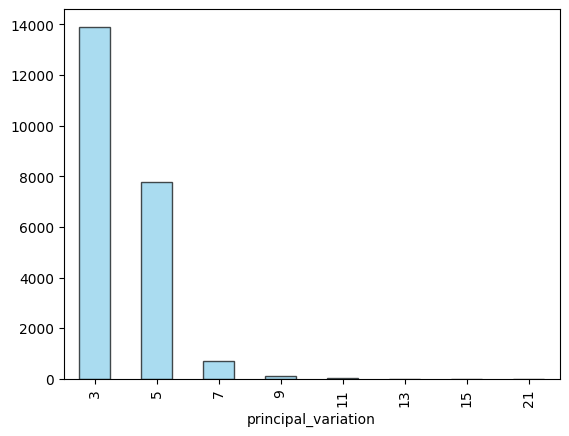

In [18]:
# %pip install matplotlib numpy
import matplotlib.pyplot as plt
import numpy as np

continuation_key = 'principal_variation'
data = puzzles[continuation_key].apply(len)
data.value_counts().plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
# list(itertools.islice(zip(puzzles[continuation_key], data), 5))
# LeelaBoard.from_puzzle(puzzles.iloc[0]).plot()

['h7g7', 'g8g7', 'g5e6', 'g7g8', 'e6d8']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 44.72it/s]


tensor([ 7.1526e-05,  7.6544e-04, -3.9405e-03, -1.7762e-05,  1.4031e-04,
         3.6013e-04,  3.5369e-04, -3.9196e-04,  1.0442e-03,  6.7174e-04,
         2.9635e-04, -5.8663e-04,  2.1446e-04,  2.8765e-04,  1.2835e-03,
        -8.0824e-05,  5.2333e-05,  2.1636e-04,  5.6565e-04,  1.0793e-03,
        -3.9399e-04, -8.8261e-03,  8.8108e-04,  8.8215e-05,  4.7958e-04,
        -5.4717e-05,  3.0768e-04, -1.7809e-03,  5.6469e-04, -2.7490e-04,
         1.6785e-04, -4.1246e-05,  8.2600e-04,  9.2030e-04, -1.2720e-04,
         1.8889e-03, -5.8252e-03,  1.3617e-03, -4.2940e-03,  6.5553e-04,
         9.8813e-04,  1.1516e-04, -1.3295e-03, -6.3076e-03,  1.0073e-02,
        -8.9465e-03, -7.0190e-04, -1.3527e-03,  6.5696e-04,  1.6148e-02,
        -2.8896e-04,  4.6919e-02, -2.5678e-04,  1.4141e-03,  3.0178e-01,
        -3.4908e-03,  9.3400e-04,  6.7067e-04, -1.6781e-03,  1.1617e-02,
        -7.0190e-04,  1.3113e-06, -6.9687e-03, -2.1054e-03], device='mps:0')
tensor(0.3018, device='mps:0')


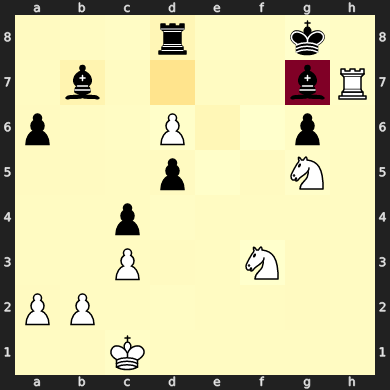

In [21]:
def get_log_odds_reduction(puzzle):
    log_odds_reductions = -activation_patch(
        module_func=model.headwise_attention_output,
        # Layer, head, output square:
        locations=list(itertools.product([12], [12], range(64))),
        model=model,
        # We could also pass in board and corrupted_board manually instead
        puzzles=puzzle,
    )
    # print(puzzle)
    # print(log_odds_reductions.shape)
    if np.nan in log_odds_reductions:
        print("WARNING: log_odds_reductions contains nan values")
    print(log_odds_reductions)
    print(torch.max(log_odds_reductions))
    return log_odds_reductions

puzzle = puzzles.iloc[2]
print(puzzle['principal_variation'])

board = LeelaBoard.from_puzzle(puzzle)
board.plot(get_log_odds_reduction(puzzle))


In [22]:
def is_white_to_move(fen: str) -> bool:
    # split the fen string into its components
    components = fen.split()
    if len(components) < 2:
        raise ValueError("Invalid FEN: Missing fields")
    # check the active color
    return components[1] == 'w'

# example usage:
# fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
# print(is_white_to_move(fen))  # output: True (white to move)

puzzles['turn'] = puzzles['FEN'].map(is_white_to_move)

In [23]:
# filter out 3 move puzzles (where len(puzzles['principal_variation']) == 3)
# classify 3 move puzzles by their destination square (either 111, 112, 122, or 123)
    # do this via n^2 algorithm (if the destination square is same as previous, assign that number)
    # eventually turn this into a library function

three_move_puzzles = puzzles[puzzles['principal_variation'].map(len) == 3]
three_move_puzzles.head(20)

def get_target_square(move):
    return move[2:4]
    
three_move_puzzles['target_squares'] = puzzles['principal_variation'].map(lambda variation: [get_target_square(move) for move in variation])
three_move_puzzles['correct_square'] = three_move_puzzles['target_squares'].map(lambda x: x[0])

def classify(target_squares):
    classification = [1] + [0] * (len(target_squares)-1)
    for i in range(1, len(target_squares)):
        if target_squares[i] in target_squares[:i]:
            classification[i] = classification[target_squares.index(target_squares[i])]
        else:
            classification[i] = max(classification[:i]) + 1

    return ''.join(str(i) for i in classification)

three_move_puzzles['classification'] = three_move_puzzles['target_squares'].map(classify)
three_move_puzzles.head(20)

/var/folders/w3/j02t23557nzf01m3t28w6w6c0000gn/T/ipykernel_14496/4075322400.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_move_puzzles['target_squares'] = puzzles['principal_variation'].map(lambda variation: [get_target_square(move) for move in variation])
/var/folders/w3/j02t23557nzf01m3t28w6w6c0000gn/T/ipykernel_14496/4075322400.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_move_puzzles['correct_square'] = three_move_puzzles['target_squares'].map(lambda x: x[0])
/var/folders/w3/j

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,...,full_wdl,sparring_full_pv_probs,sparring_full_model_moves,sparring_wdl,different_targets,corrupted_fen,turn,target_squares,correct_square,classification
22,001w5,1rb2rk1/q5P1/4p2p/3p3p/3P1P2/2P5/2QK3P/3R2R1 b...,f8f7 c2h7 g8h7 g7g8q,1073,77,91,189,advancedPawn attraction mate mateIn2 middlegam...,https://lichess.org/0e1vxAEn/black#57,NaN,...,"[0.561260461807251, 0.18697379529476166, 0.251...","[0.006373010575771332, 1.0, 0.15674205124378204]","[d1a1, g8h7, g7g8q]","[0.0053426711820065975, 0.9625791907310486, 0....",False,1r4k1/q4rP1/2b1p2p/3p3p/3P1P2/2P5/2QK3P/3R2R1 ...,False,"[h7, h7, g8]",h7,112
170,00AoZ,8/1R6/p1pk4/6bp/1QP5/P7/KP6/3r2q1 b - - 2 44,g1c5 b7d7 d6d7 b4c5,1023,77,93,3354,advantage deflection endgame short,https://lichess.org/356BAYqk/black#87,NaN,...,"[0.8298567533493042, 0.16442830860614777, 0.00...","[0.03029155358672142, 0.9142314195632935, 0.81...","[b4b3, d6d7, b4c5]","[0.01180175319314003, 0.947725236415863, 0.040...",False,8/1R6/p1pk4/2q4p/1QP5/P6b/KP6/3r4 w - - 3 45,False,"[d7, d7, c5]",d7,112
182,00Bg4,3r2k1/1q3ppp/p2rp3/Qp1B4/7P/P4P2/1PP3P1/1K1R3R...,d6d5 a5d8 d5d8 d1d8,1374,85,75,303,backRankMate endgame mate mateIn2 short xRayAt...,https://lichess.org/6qWf8wOP/black#41,NaN,...,"[0.9491999745368958, 0.04444213956594467, 0.00...","[0.008508995175361633, 1.0, 0.772297203540802]","[d1d5, d5d8, d1d8]","[0.007286431733518839, 0.983742892742157, 0.00...",False,3r4/1q3ppp/p3p3/Qp1r4/5k1P/P4P2/1PP3P1/1K1R3R ...,False,"[d8, d8, d8]",d8,111
204,00DTg,r2qk2r/1pp2ppp/p1pb1n2/4P3/3Q4/2N2b2/PPP2PPP/R...,e5f6 d6h2 g1h2 d8d4,1071,83,94,2458,crushing discoveredAttack kingsideAttack middl...,https://lichess.org/EqbT8Dsc#18,Ruy_Lopez Ruy_Lopez_Exchange_Variation,...,"[0.7830476760864258, 0.1093672439455986, 0.107...","[0.0486067533493042, 0.9339202642440796, 0.775...","[d8f6, g1h2, d8d4]","[0.021351320669054985, 0.891577959060669, 0.08...",False,r2qk2r/1pp2ppp/p1pb1P2/8/8/2N2b2/PPPQ1PPP/R1B2...,True,"[h2, h2, d4]",h2,112
219,00EXS,r3r1k1/p2Q1p1p/1p2p1p1/8/1P1P4/P3P3/1B2Nb1q/2K...,f1h1 f2e3 c1b1 h2e2,1558,86,56,28,advantage discoveredAttack middlegame short,https://lichess.org/CeNY4SjC#36,NaN,...,"[0.3333595097064972, 0.3103189468383789, 0.356...","[0.03494846820831299, 0.8162358999252319, 0.58...","[h2g2, c1b1, h2e2]","[0.007694287225604057, 0.9609947800636292, 0.0...",True,r3r1k1/p2Q3p/1p2p1p1/8/1P1P4/P3P3/1B2Nb1q/2KR3...,True,"[e3, b1, e2]",e3,123
373,00NUc,6k1/6pp/1PP5/4b3/3p4/Br5P/4prP1/R5RK w - - 1 30,c6c7 b3h3 g2h3 f2h2,1650,122,81,50,endgame mate mateIn2 sacrifice short,https://lichess.org/8FRZVN6d#58,NaN,...,"[0.24129429459571838, 0.6679720282554626, 0.09...","[0.0017951878253370523, 1.0, 0.8596315383911133]","[b3c3, g2h3, f2h2]","[0.005384400952607393, 0.9865591526031494, 0.0...",False,6k1/2P4p/1P6/4b3/3p4/Br5P/4prP1/R5RK b - - 0 30,True,"[h3, h3, h2]",h3,112
477,00TU2,1k1r4/1p3Qp1/p2q3p/3N4/1b6/8/PP3PPP/2R3K1 w - ...,d5b4 d6d1 c1d1 d8d1,561,81,99,1081,backRankMate endgame mate mateIn2 sacrifice short,https://lichess.org/p32396Rd#42,NaN,...,"[0.6312634944915771, 0.21408513188362122, 0.15...","[0.019247423857450485, 1.0, 0.33872464299201965]","[d6b4, c1d1, d8d1]","[0.0008122252183966339, 0.996202290058136, 0.0...",False,1k1r4/1p3Qp1/p2q3p/8/1N6/8/PP3PPP/K1R5 b - - 0 22,True,"[d1, d1, d1]",d1,111
538,00Wyh,2r5/8/8/pNp1r2p/3kNppP/1P1P4/2R2K2/8 b - - 2 42,d4d3 c2d2 d3e4 b5d6,1673,77,94,9840,endgame mate mateIn2 sacrifice short,https://lichess.org/2mLJufzX/black#83,NaN,...,"[0.03521887958049774, 0.35142573714256287, 0.6...","[0.0353325791656971, 1.0, 0.29109397530555725]","[c2c3, d3e4, b5d6]","[0.010604179464280605, 0.935430109500885, 0.05...",True,2r5/8/1r6/pNp4p/4NppP/1P1k4/2R2K2/8 w - - 0 43,False,"[d2, e4, d6]",d2,123
596,00aBq,r2r2k1/pp3ppp/1qn2b2/3R4/4QB2/1P3N2/P4PPP/4R1K...,d8d5 e4e8 a8e8 e1e8,927,83,88,315,backRankMate mate mateIn2 middlegame sacrifice...,https://lichess.org/0AybhVJm/black#35,Queens_Pawn_Game Queens

In [25]:
def get_all_log_odds_reductions(puzzles):
    log_odds_reductions = -activation_patch(
        module_func=model.headwise_attention_output,
        # Layer, head, output square:
        locations=list(itertools.product(range(15), range(24), range(64))),
        model=model,
        # We could also pass in board and corrupted_board manually instead
        puzzles=puzzles,
    )
    # print(puzzle)
    # print(log_odds_reductions.shape)
    # if np.nan in log_odds_reductions:
    #     print("WARNING: log_odds_reductions contains nan values")
    # print(log_odds_reductions)
    # print(torch.max(log_odds_reductions))
    return log_odds_reductions


# three_move_puzzles.head(20)
reductions = get_all_log_odds_reductions(three_move_puzzles)

  2%|███                                                                                                                                                                                                         | 349/23040 [00:53<58:01,  6.52it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# create a tensor of shape [1, 360] with random values
data_tensor = reductions.cpu()

# reshape the tensor into a 24x15 grid (column-major order)
data_grid = data_tensor.view(24, 15).numpy()

# create the heat map
plt.figure(figsize=(10, 6))
plt.imshow(data_grid, aspect="auto", cmap="YlOrRd", origin="lower")

# set x and y ticks
plt.xticks(ticks=np.arange(0, 15, 2), labels=np.arange(0, 15, 2))
plt.yticks(ticks=np.arange(0, 24, 2), labels=np.arange(0, 24, 2))

# label axes
plt.xlabel("Layer (attention block)")
plt.ylabel("Head (attention head)")

# add a color bar for the heat map
plt.colorbar(label="Value")

# display the plot
plt.title("Attention Heat Map")
plt.show()